Loading GS from ./nequip_ase_gs/md_nequip.traj...
  - Processing 26 frames...
Loading 6e from ./nequip_ase_6e/md_nequip.traj...
  - Processing 26 frames...
Loading 10e from ./nequip_ase_10e/md_nequip.traj...
  - Processing 26 frames...
Loading 16e from ./nequip_ase_16e/md_nequip.traj...
  - Processing 26 frames...


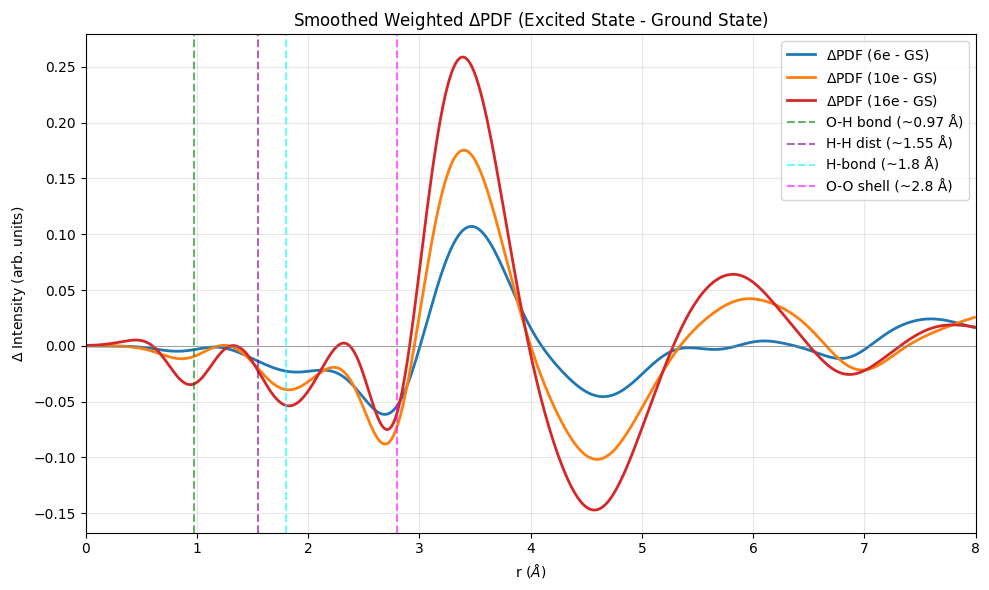

Plot saved to Delta_PDF_Comparison.png


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
import os

# --- Configuration ---
directories = {
    'GS': './nequip_ase_gs',   # Directory for Ground State
    '6e': './nequip_ase_6e',   # Directory for 6 electron excited state
    '10e': './nequip_ase_10e', # Directory for 10 electron excited state
    '16e': './nequip_ase_16e'  # Directory for 16 electron excited state
}
traj_filename = 'md_nequip.traj'
traj_slice = '25:' # Skip equilibration
r_max = 8.0
nbins = 400
sigma = 0.53 / 2.355 # Smoothing width

# Scattering weights (approximate for UED)
ws = np.asarray([1.0, 0.4, 0.16]) # O-O, O-H, H-H
wtot = ws.sum()

# --- Helper Functions ---

def calculate_rdf_components(frames, r_max, nbins):
    """Calculates partial RDFs: O-O, O-H, H-H"""
    dr = r_max / nbins
    r = np.linspace(dr/2, r_max - dr/2, nbins)
    bin_edges = np.linspace(0, r_max, nbins + 1)
    
    histograms = {label: np.zeros(nbins) for label in ['OO', 'OH', 'HH']}
    
    n_frames = len(frames)
    avg_vol = np.mean([a.get_volume() for a in frames])
    
    # Counts assume constant composition
    syms = frames[0].get_chemical_symbols()
    n_O = syms.count('O')
    n_H = syms.count('H')
    
    if n_O == 0: return r, None 

    print(f"  - Processing {n_frames} frames...")
    
    for atoms in frames:
        # Full distance matrix (mic=True for PBC)
        D_matrix = atoms.get_all_distances(mic=True)
        symbols = np.array(atoms.get_chemical_symbols())
        mask_O = (symbols == 'O')
        mask_H = (symbols == 'H')
        
        # O-O
        d_oo = D_matrix[np.ix_(mask_O, mask_O)]
        d_oo = d_oo[d_oo > 1e-5] # remove self-interactions
        histograms['OO'] += np.histogram(d_oo, bins=bin_edges)[0]
        
        # O-H
        d_oh = D_matrix[np.ix_(mask_O, mask_H)].flatten()
        histograms['OH'] += np.histogram(d_oh, bins=bin_edges)[0]
        
        # H-H
        d_hh = D_matrix[np.ix_(mask_H, mask_H)]
        d_hh = d_hh[d_hh > 1e-5] # remove self-interactions
        histograms['HH'] += np.histogram(d_hh, bins=bin_edges)[0]

    # Normalization
    shell_vols = 4.0 * np.pi * (r**2) * dr
    rho_O = n_O / avg_vol
    rho_H = n_H / avg_vol
    
    # Normalization factors
    norm_OO = n_frames * n_O * ((n_O-1)/avg_vol) * shell_vols
    norm_OH = n_frames * n_O * rho_H * shell_vols
    norm_HH = n_frames * n_H * ((n_H-1)/avg_vol) * shell_vols
    
    g_OO = histograms['OO'] / norm_OO
    g_OH = histograms['OH'] / norm_OH
    g_HH = histograms['HH'] / norm_HH
    
    return r, {'OO': g_OO, 'OH': g_OH, 'HH': g_HH}

def smooth_signal(r, signal, sigma):
    """Convolves signal with Gaussian kernel"""
    smoothed = np.zeros_like(signal)
    for i in range(len(r)):
        weights = np.exp(-0.5 * ((r - r[i]) / sigma)**2)
        weights /= weights.sum() # Normalize kernel
        smoothed[i] = np.sum(signal * weights)
    return smoothed

# --- Main Processing Loop ---

results = {} # To store smoothed I(r) for each state

for label, folder in directories.items():
    fpath = os.path.join(folder, traj_filename)
    print(f"Loading {label} from {fpath}...")
    
    if not os.path.exists(fpath):
        print(f"  WARNING: File not found: {fpath}. Skipping.")
        continue
        
    try:
        frames = read(fpath, index=traj_slice)
        if not frames: 
            print("  No frames loaded.")
            continue
            
        r, g_partials = calculate_rdf_components(frames, r_max, nbins)
        
        # Weighted Sum
        I_raw = (g_partials['OO']*ws[0] + g_partials['OH']*ws[1] + g_partials['HH']*ws[2]) / wtot
        
        # Smoothing
        I_smooth = smooth_signal(r, I_raw, sigma)
        
        results[label] = I_smooth
        
    except Exception as e:
        print(f"  Error processing {label}: {e}")

# --- Plotting Delta PDF ---

if 'GS' not in results:
    print("Error: Ground State (GS) data missing. Cannot calculate Delta PDF.")
else:
    I_gs = results['GS']
    
    plt.figure(figsize=(10, 6))
    
    colors = {'6e': 'tab:blue', '10e': 'tab:orange', '16e': 'tab:red'}
    
    # Plot Delta PDFs
    for label in ['6e', '10e', '16e']:
        if label in results:
            delta_pdf = results[label] - I_gs
            plt.plot(r, delta_pdf, label=f'$\Delta$PDF ({label} - GS)', color=colors[label], linewidth=2)
    
    # Add vertical lines for theoretical peaks
    peaks = [
        (0.97, 'O-H bond'),
        (1.55, 'H-H dist'),
        (1.80, 'H-bond'),
        (2.80, 'O-O shell')
    ]
    peak_colors = ['green', 'purple', 'cyan', 'magenta']

    for i, (pos, label) in enumerate(peaks):
        plt.axvline(x=pos, color=peak_colors[i], linestyle='--', alpha=0.6, linewidth=1.5, label=f'{label} (~{pos} Å)')

    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.title('Smoothed Weighted $\Delta$PDF (Excited State - Ground State)')
    plt.xlabel('r ($\AA$)')
    plt.ylabel('$\Delta$ Intensity (arb. units)')
    plt.legend()
    plt.xlim(0, r_max)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('Delta_PDF_Comparison.png', dpi=300)
    plt.show()
    print("Plot saved to Delta_PDF_Comparison.png")